In [1]:
libs <- c(
    'dplyr',
    'tidyr',
    'stringr',
    'ggplot2',
    'GenomicRanges',
    'RPostgreSQL',
    'doMC',
    'numbers',
    'doParallel',
    'fst'
)

for (lib in libs) {
        if (!require(lib, character.only = TRUE, quietly = TRUE)) {
            install.packages(lib, repos='http://cran.us.r-project.org')
        }
}

library(BSgenome.Hsapiens.UCSC.hg38)
hg38 <- BSgenome.Hsapiens.UCSC.hg38

source("my_R_functions/utility_functions.R")
source("my_R_functions/stat_functions.R")
source("my_R_functions/plot_functions.R")
source("/ssd/mrichard/github/BDDS/trenadb/src/utils.R")
source("/ssd/mrichard/github/BDDS/footprints/testdb/src/dbFunctions.R")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind

We'll start by loading our positive/negative data from the previous notebook. Remember that this contains:

1. Information for 55 TFs that appear in the ChipSeq, our mapping of TF-motif, and JASPAR motifs
2. Positives: FIMO instances of the motifs from these TFs that have hits (overlaps) with ChipSeq
3. Negatives: FIMO instances of the motifs from these TFs that don't overlap with ChipSeq

Recall that we took 9 times as many negatives as positives, when possible

In [2]:
#all.TF.df <- read.fst("/ssd/mrichard/data/all.TF.fimo.samples.ratio.ALL.df.fst")
all.TF.df <- read.fst("/ssd/mrichard/data/NB2.input.fst")

In [17]:
format(nrow(all.TF.df),big.mark = ",")

[1] "105,440,657"

We're also going to load up the lymphoblast databases; basically, we've been doing all of this in a tissue-agnostic way. We're going to now bring the footprinting into it. And I think lymphoblast is the pertinent tissue

*Note that the lymphoblast stuff below is with the previous database; might want to do this with the new ones!

In [19]:
db_lymph_hint <- src_postgres(drv=dbDriver("PostgreSQL"),
                              user="trena",
                              password="trena",
                              #dbname="lymphoblast_hint", # Old options from Whovian
                              #host="whovian",
                              port="5432",
                              dbname = "lymphoblast_hint_20",
                              host = "localhost")
db_lymph_well <- src_postgres(drv=dbDriver("PostgreSQL"),
                              user="trena",
                              password="trena",
                              #dbname="lymphoblast_wellington", # Old options from Whovian
                              #host="whovian",
                              port="5432",
                              dbname = "lymphoblast_wellington_20",
                              host = "localhost")
hint_regions <- tbl(db_lymph_hint, "regions")
hint_hits    <- tbl(db_lymph_hint, "hits")
well_regions <- tbl(db_lymph_well, "regions")
well_hits    <- tbl(db_lymph_well, "hits")

## function to loop over all chromosomes

We've got HINT and Wellington; we want to merge these together, so we do the following in a function, for a given chromosome number:

1. Grab all the FIMO entries for that chromosome (this is BIG!)
2. For HINT and Wellington, join the regions and hits tables (adds chromosome to hits), and grab just the start, end, strand, motif name, and method-specific score.
3. For a given unique start/end/strand, you can have multiple hits. So count how many hits each location has and store that number, plus grab the maximum score. Do this for both HINT and Wellington to reduce the number of rows and keep just the most important score info (max and frequency)
4. Merge together the FIMO, HINT, and Wellington tables; so now each motif instance in FIMO is listed with how many hits it had in HINT/Wellington and what its max score was in each case. Return this useful data frame!

In [25]:
merge_fimo_hint_wellington_one_chrom <- function(chrom_str,
                                                 fimo_tbl,
                                                 hint_regions_tbl,
                                                 hint_hits_tbl,
                                                 well_regions_tbl,
                                                 well_hits_tbl
                                                ) {
    
    # some tables use chr22 and some just use 22
    chrom_long_str <- paste("chr",chrom_str, sep="")
    
    # select one chromosome from my data table
    fimo_tbl %>%
    filter(chrom==chrom_str) %>%
    select(-empty) ->
    chrom_all_tf_df
    
    # select one chromosome from hint
    hint_regions_tbl %>%
    filter(chrom==chrom_long_str) %>%
    left_join(hint_hits_tbl, by="loc") %>%
    select(start, endpos, strand, name, h_score = score1)  %>%
    # Keep only max HINT score but count total nontrivial scores
    group_by(start, endpos, name, strand) %>%
    mutate(h_count = n(),h_max_score = max(h_score)) %>%
    select(-h_score) %>%
    as_tibble ->
    chrom_hint_all_tbl
    
    # Grab just the distinct ones
    chrom_hint_all_tbl %>%
    distinct(start, endpos, name, strand, .keep_all = TRUE) ->
    chrom_hint_unique_tbl

    # select one chromosome from wellington
    well_regions_tbl %>%
    filter(chrom==chrom_long_str) %>%
    left_join(well_hits_tbl, by="loc") %>%
    select(start, endpos, strand, name, w_score = score1) %>%
    # keep only max hint score but count total nontrivial scores
    group_by(start, endpos, name, strand) %>%
    mutate(w_count = n(),w_min_score = min(w_score)) %>%
    select(-w_score) %>%
    as_tibble ->
    chrom_well_all_tbl
    
    # keep only min wellington score but count total nontrivial scores
    chrom_well_all_tbl %>%
    distinct(start, endpos, name, strand, .keep_all = TRUE) ->
    chrom_well_unique_tbl
    
    # merge hint and wellington into my table
    chrom_all_tf_df %>%
    left_join(chrom_hint_unique_tbl, by=c("start", "endpos", "strand", "motifname"="name")) %>%
    left_join(chrom_well_unique_tbl, by=c("start", "endpos", "strand", "motifname"="name")) %>%
    replace_na(list(h_count=0, w_count=0, h_max_score=0, w_min_score=0)) ->
    chrom_all_tf_df_merged
    
    return(chrom_all_tf_df_merged)
}

## Perform loop over all chromosomes

*** I'm pretty sure we can parallelize this ***

Doing the loop, we now have a really big data frame. We feed in the version of FIMO that essentially has positives/negatives based on ChipSeq; this is the basis we're starting with. So now what we have is:

* A data frame of motifs from our ChipSeq TF set, marked as "positives" or "negatives" WRT ChipSeq hits
* The number of hits each method (HINT/Wellington) has with each motif
* The maximum score (in absolute value; Wellington is negative, so it's technically the minimum) for each method
* All the other meta data (strand, start/end, sequence, motif score, motif name)

In [26]:
big_list <- list()
counter <- 1

now.time <- Sys.time()
# I added X and Y here too
for (chr_str in as.character(c(1:22,"X","Y"))) {
    message(paste("working on chromosome",chr_str))
    
    big_list[[counter]] <- merge_fimo_hint_wellington_one_chrom(chr_str,
                                               all.TF.df,
                                               hint_regions,
                                               hint_hits,
                                               well_regions,
                                               well_hits)
    counter <- counter + 1
    message(paste("Time elapsed:", Sys.time() - now.time))
}

working on chromosome 1
Time elapsed (s): 15.6031579534213
working on chromosome 2
Time elapsed (s): 26.3009862939517
working on chromosome 3
Time elapsed (s): 36.9136778990428
working on chromosome 4
Time elapsed (s): 47.8429852247238
working on chromosome 5
Time elapsed (s): 1.08403926001655
working on chromosome 6
Time elapsed (s): 1.35446503023307
working on chromosome 7
Time elapsed (s): 1.63064441475603
working on chromosome 8
Time elapsed (s): 1.90545977691809
working on chromosome 9
Time elapsed (s): 2.20330809593201
working on chromosome 10
Time elapsed (s): 2.47725754115317
working on chromosome 11
Time elapsed (s): 2.74336080544525
working on chromosome 12
Time elapsed (s): 3.01459826118416
working on chromosome 13
Time elapsed (s): 3.22973631335629
working on chromosome 14
Time elapsed (s): 3.46308344165484
working on chromosome 15
Time elapsed (s): 3.69737767775853
working on chromosome 16
Time elapsed (s): 3.95458986467785
working on chromosome 17
Time elapsed (s): 4.2310

In [30]:
str(big_list)

List of 24
 $ :Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	8548465 obs. of  14 variables:
  ..$ motifname  : chr [1:8548465] "Mmusculus-jaspar2016-Nfe2l2-MA0150.2" "Mmusculus-jaspar2016-Bach1::Mafk-MA0591.1" "Hsapiens-jaspar2016-JUND(var.2)-MA0492.1" "Hsapiens-jaspar2016-JUND(var.2)-MA0492.1" ...
  ..$ chrom      : chr [1:8548465] "1" "1" "1" "1" ...
  ..$ start      : int [1:8548465] 1677938 1677939 1828558 2255789 2255823 2255891 2255917 2255949 2255916 2255983 ...
  ..$ endpos     : int [1:8548465] 1677952 1677953 1828572 2255803 2255837 2255905 2255931 2255963 2255929 2255997 ...
  ..$ strand     : chr [1:8548465] "+" "+" "-" "-" ...
  ..$ motifscore : num [1:8548465] 13.35 11.71 9.73 13.72 13.72 ...
  ..$ pval       : num [1:8548465] 1.13e-05 1.37e-05 9.18e-05 1.48e-05 1.48e-05 1.48e-05 8.28e-06 1.48e-05 6.68e-05 1.48e-05 ...
  ..$ sequence   : chr [1:8548465] "CACTGTGACTCCGCA" "ACTGTGACTCCGCAG" "TTTTGTGAGGTCACT" "GGAAATGAGGTCAGG" ...
  ..$ loc        : chr [1:8548465] "chr1:1677938

In [31]:
all.TF.df.fimo.hint.well <- bind_rows(big_list)

In [32]:
str(all.TF.df.fimo.hint.well)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	105440178 obs. of  14 variables:
 $ motifname  : chr  "Mmusculus-jaspar2016-Nfe2l2-MA0150.2" "Mmusculus-jaspar2016-Bach1::Mafk-MA0591.1" "Hsapiens-jaspar2016-JUND(var.2)-MA0492.1" "Hsapiens-jaspar2016-JUND(var.2)-MA0492.1" ...
 $ chrom      : chr  "1" "1" "1" "1" ...
 $ start      : int  1677938 1677939 1828558 2255789 2255823 2255891 2255917 2255949 2255916 2255983 ...
 $ endpos     : int  1677952 1677953 1828572 2255803 2255837 2255905 2255931 2255963 2255929 2255997 ...
 $ strand     : chr  "+" "+" "-" "-" ...
 $ motifscore : num  13.35 11.71 9.73 13.72 13.72 ...
 $ pval       : num  1.13e-05 1.37e-05 9.18e-05 1.48e-05 1.48e-05 1.48e-05 8.28e-06 1.48e-05 6.68e-05 1.48e-05 ...
 $ sequence   : chr  "CACTGTGACTCCGCA" "ACTGTGACTCCGCAG" "TTTTGTGAGGTCACT" "GGAAATGAGGTCAGG" ...
 $ loc        : chr  "chr1:1677938-1677952" "chr1:1677939-1677953" "chr1:1828558-1828572" "chr1:2255789-2255803" ...
 $ cs_hit     : num  1 1 1 1 1 1 1 1 1 1 ...
 $ h_count 

## Rename and save

Doing this took a lot of time (as in hours); we'll save it in this file as "big_df" for later

In [33]:
#save(all.TF.df.fimo.hint.well, file="/ssd/mrichard/data/all.TF.df.fimo.hint.well.seed20.10M.Rdata")
write.fst(all.TF.df.fimo.hint.well, path = "/ssd/mrichard/data/all.TF.df.fimo.hint.well.seed20.ALL.fst")

## Explore data

We're going to explore our big data frame in 3 plots:

1. Looking at the density of both positive and negative as a function of Wellington score (asinh-transformed)
2. Looking at the density of both positive and negative as a function of HINT score (asinh-transformed)
3. Looking at Wellington score vs. HINT score for both positive and negative

In [ ]:
all.TF.df.fimo.hint.well <- read.fst("/ssd/mrichard/data/all.TF.df.fimo.hint.well.seed20.ALL.fst")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


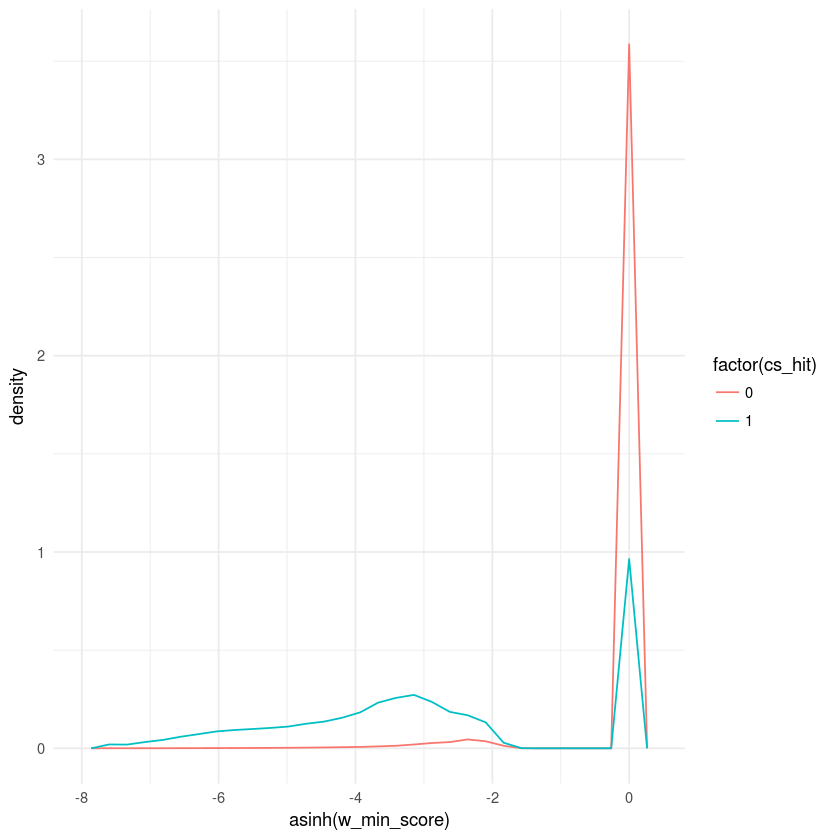

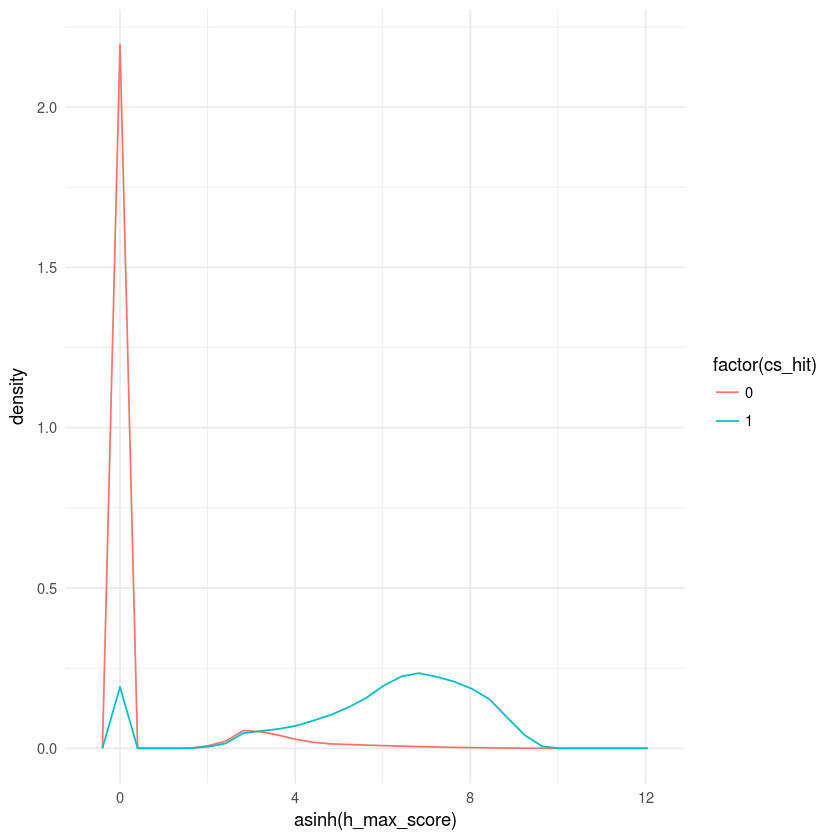

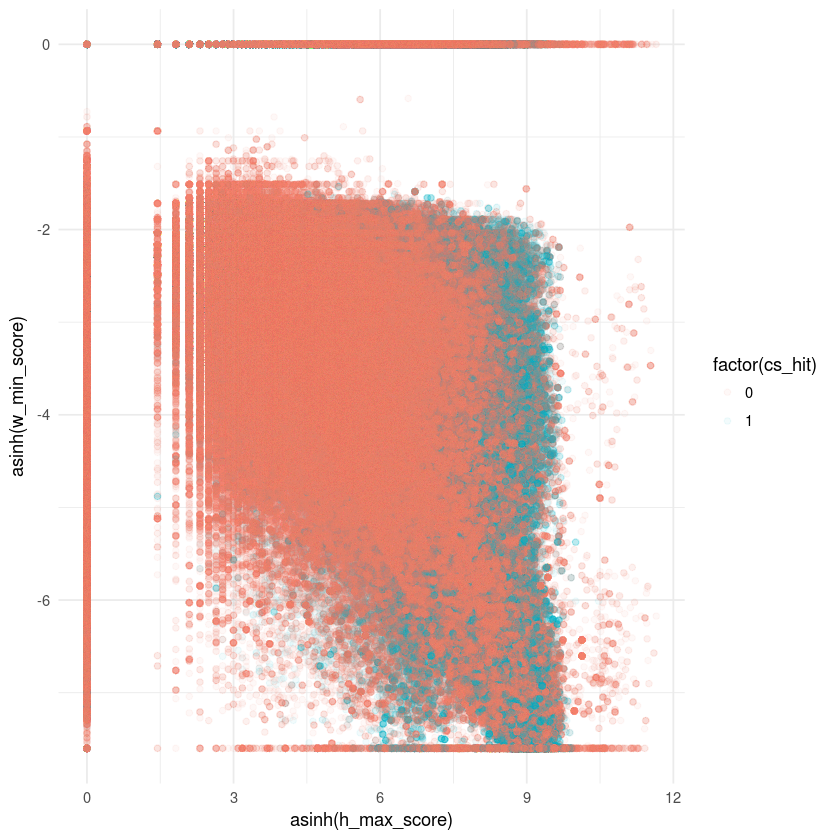

In [34]:
all.TF.df.fimo.hint.well %>%
ggplot +
geom_freqpoly(aes(x=asinh(w_min_score), y= ..density.., color=factor(cs_hit))) +
theme_minimal()

all.TF.df.fimo.hint.well %>%
ggplot +
geom_freqpoly(aes(x=asinh(h_max_score), y= ..density.., color=factor(cs_hit))) +
theme_minimal()

all.TF.df.fimo.hint.well %>%
ggplot +
geom_point(
    aes(x=asinh(h_max_score),
        y=asinh(w_min_score),
        color=factor(cs_hit)),
    alpha=0.05) +
theme_minimal()

In [35]:
# Wellington cutoff
sinh(-1.6)

[1] -2.375568

In [36]:
# Hint cutoff
sinh(2)

[1] 3.62686

In [37]:
length(unique(all.TF.df.fimo.hint.well$motifname))

[1] 119

In [39]:
length(unique(all.TF.df$motifname))

[1] 119